#### Importing the Packages

In [1]:
import pandas as pd
import numpy as np
import pandas_profiling

import scipy.stats as stats

import matplotlib.pyplot as plt
%matplotlib Inline
import seaborn as sns
sns.set() 

from sklearn.preprocessing import OrdinalEncoder,LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV


C:\Users\1005\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


____________________________________________________________________________________________________________________________

#### Data Dictionary
- DBNOs - Number of enemy players knocked.
- assists - Number of enemy players this player damaged that were killed by teammates.
- boosts - Number of boost items used.
- damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.
- headshotKills - Number of enemy players killed with headshots.
- heals - Number of healing items used.
- Id - Player’s Id
- killPlace - Ranking in match of number of enemy players killed.
- killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
- killStreaks - Max number of enemy players killed in a short amount of time.
- kills - Number of enemy players killed.
- longestKill - Longest distance between player and player killed at time of death. 
- matchDuration - Duration of match in seconds.
- matchId - ID to identify match. There are no matches that are in both the training and testing set.
- matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
- rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
- revives - Number of times this player revived teammates.
- rideDistance - Total distance traveled in vehicles measured in meters.
- roadKills - Number of kills while in a vehicle.
- swimDistance - Total distance traveled by swimming measured in meters.
- teamKills - Number of times this player killed a teammate.
- vehicleDestroys - Number of vehicles destroyed.
- walkDistance - Total distance traveled on foot measured in meters.
- weaponsAcquired - Number of weapons picked up.
- winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
- groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
- numGroups - Number of groups we have data for in the match.
- maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
- winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

____________________________________________________________________________________________________________________________


#### Importing the Data Set 

In [2]:
pubg_train=pd.read_csv('train_V2.csv')

#### Inspecting Missing Data 

In [3]:
pubg_train.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

In [4]:
pubg_train[pubg_train.winPlacePerc.isna()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [5]:
pubg_train[pubg_train.matchId=='224a123c53e008']

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


- Its not possible to have match with a single player as only one match Id is found so it may be invalid

#### Removing Missing Record

In [6]:
pubg_train.dropna(inplace=True)

In [7]:
pubg_train.reset_index(drop=True,inplace=True)

In [8]:
print("No of Rows: {} | No. of Columns: {}".format(pubg_train.shape[0],pubg_train.shape[1]))

No of Rows: 4446965 | No. of Columns: 29


____________________________________________________________________________________________________________________________

#### Reducing the memory usage by converting columns into proper data type

In [9]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum()/(1024**2)
    
    print('Memory usage of dataframe before optimisation is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum()/(1024**2)
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Memory Decreased by {:.2f}%'.format(((start_mem - end_mem)/start_mem)*100))
    
    return df


In [10]:
reduce_mem_usage(pubg_train)

Memory usage of dataframe before optimisation is 983.90 MB
Memory usage after optimization is: 498.81 MB
Memory Decreased by 49.30%


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,...,0,0.000000,0,0.000000,0,0,244.7500,1,1466,0.444336
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,...,0,0.004501,0,11.039062,0,0,1434.0000,5,0,0.640137
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,...,0,0.000000,0,0.000000,0,0,161.7500,2,0,0.775391
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,...,0,0.000000,0,0.000000,0,0,202.7500,3,0,0.166748
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,...,0,0.000000,0,0.000000,0,0,49.7500,2,0,0.187500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446960,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.00000,0,0,0,74,...,0,1292.000000,0,0.000000,0,0,1019.0000,3,1507,0.178589
4446961,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.15625,0,0,0,69,...,0,0.000000,0,0.000000,0,0,81.6875,6,0,0.293457
4446962,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.06250,0,0,0,66,...,0,0.000000,0,2.183594,0,0,788.5000,4,0,0.481445
4446963,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.37500,1,1,2,11,...,2,0.000000,0,0.000000,0,0,2748.0000,8,0,0.799805


____________________________________________________________________________________________________________________________

#### Data Inspection

In [11]:
pubg_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446965 entries, 0 to 4446964
Data columns (total 29 columns):
 #   Column           Dtype   
---  ------           -----   
 0   Id               category
 1   groupId          category
 2   matchId          category
 3   assists          int8    
 4   boosts           int8    
 5   damageDealt      float16 
 6   DBNOs            int8    
 7   headshotKills    int8    
 8   heals            int8    
 9   killPlace        int8    
 10  killPoints       int16   
 11  kills            int8    
 12  killStreaks      int8    
 13  longestKill      float16 
 14  matchDuration    int16   
 15  matchType        category
 16  maxPlace         int8    
 17  numGroups        int8    
 18  rankPoints       int16   
 19  revives          int8    
 20  rideDistance     float16 
 21  roadKills        int8    
 22  swimDistance     float16 
 23  teamKills        int8    
 24  vehicleDestroys  int8    
 25  walkDistance     float16 
 26  weaponsAcquire

In [12]:
print("No of Rows: {} | No. of Columns: {}".format(pubg_train.shape[0],pubg_train.shape[1]))

No of Rows: 4446965 | No. of Columns: 29


In [13]:
pubg_train.head(20)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,...,0,0.000000,0,0.000000,0,0,244.7500,1,1466,0.444336
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.500000,0,0,0,57,...,0,0.004501,0,11.039062,0,0,1434.0000,5,0,0.640137
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,...,0,0.000000,0,0.000000,0,0,161.7500,2,0,0.775391
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.906250,0,0,0,75,...,0,0.000000,0,0.000000,0,0,202.7500,3,0,0.166748
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,...,0,0.000000,0,0.000000,0,0,49.7500,2,0,0.187500
5,ff79c12f326506,289a6836a88d27,bac52627a12114,0,0,100.000000,1,1,0,44,...,0,0.000000,0,0.000000,0,0,34.6875,1,0,0.036987
6,95959be0e21ca3,2c485a1ad3d0f1,a8274e903927a2,0,0,0.000000,0,0,0,96,...,0,0.000000,0,0.000000,0,0,13.5000,1,1497,0.000000
7,311b84c6ff4390,eaba5fcb7fc1ae,292611730ca862,0,0,8.539062,0,0,0,48,...,0,2004.000000,0,0.000000,0,0,1089.0000,6,1500,0.736816
8,1a68204ccf9891,47cfbb04e1b1a2,df014fbee741c6,0,0,51.593750,0,0,0,64,...,0,0.000000,0,0.000000,0,0,800.0000,4,0,0.370361
9,e5bb5a43587253,759bb6f7514fd2,3d3031c795305b,0,0,37.281250,0,0,0,74,...,0,0.000000,0,0.000000,0,0,65.6875,1,0,0.214355


In [14]:
pubg_train.tail(20)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
4446945,f1aca3f5aeafd8,2c6765c0fc6d77,84d7e32c95913a,0,0,0.00000,0,0,0,53,...,0,0.000,0,0.000000,0,0,2592.00000,7,0,0.729004
4446946,cac9fe367120a1,d1398e8c0941f3,a27caa11cb4dfb,0,0,0.00000,0,0,0,61,...,0,0.000,0,0.000000,0,0,631.00000,4,0,0.383057
4446947,445aaa1ddc858e,b1efcbdb7ce674,05f6cd4077cd68,1,3,736.50000,4,1,2,7,...,0,0.000,0,0.000000,0,0,1685.00000,3,1500,0.791504
4446948,138e004749faf9,dbe0096979e393,5256cd7403054e,0,0,100.00000,1,0,0,32,...,0,0.000,0,0.000000,0,0,424.50000,3,0,0.145752
4446949,d05b0c4b2ff311,8248fa2552457b,88c002b589d411,0,0,203.50000,0,0,0,32,...,0,0.000,0,0.000000,0,0,1559.00000,5,0,0.500000
4446950,0381eae18c429f,c0df2e78ccce86,be06c0c5f9a47e,0,0,0.00000,0,0,0,85,...,0,0.000,0,0.000000,0,0,44.90625,1,0,0.099976
4446951,78b990601cafb6,aa64828a68bc21,8496e878b7ee1d,0,0,0.00000,0,0,0,44,...,0,0.000,0,5.328125,0,0,1177.00000,5,0,0.846191
4446952,372304ea470cad,0db6cf38e79c9e,a530fd807f535a,0,0,30.09375,0,0,0,57,...,1,0.000,0,0.000000,0,0,1025.00000,5,1551,0.592773
4446953,894c01c8e4524f,c33e793af077f9,deb3a91c03d0f3,0,0,30.09375,0,0,0,58,...,0,0.000,0,0.000000,0,0,2146.00000,6,1502,0.530762
4446954,b9155a229aedfd,570d9414a536f3,0c5ab888689674,0,0,0.00000,0,0,0,60,...,0,605.000,0,0.000000,0,0,1158.00000,3,0,0.479248


____________________________________________________________________________________________________________________________

#### Pandas Profiling

In [15]:
pandas_profiling.ProfileReport(df=pubg_train,minimal=True)

#### Observations:
- No Duplicate Records 
- Only one Missing Cells
- Roadkills is highly skewed 

____________________________________________________________________________________________________________________________

#### Anomalies in Data Set

- Its not possible to have match duration more than 10 minutes with zero walk distance and also assisting a player

In [13]:
pubg_train[(pubg_train.walkDistance==0) & (pubg_train.matchDuration>=600) & (pubg_train.assists!=0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
6673,6d3a61da07b7cb,2d8119b1544f87,904cecf36217df,2,0,346.500000,0,0,6,33,...,0,0.0,0,0.0,0,0,0.0,22,0,0.600098
11892,550398a8f33db7,c3fd0e2abab0af,db6f6d1f0d4904,2,0,1750.000000,0,4,5,3,...,0,0.0,0,0.0,0,0,0.0,13,0,0.894531
13696,b839546728f966,c703fed49cdf20,b3694f114c57ea,1,0,37.812500,0,0,0,90,...,0,0.0,0,0.0,0,0,0.0,0,0,0.032593
15989,de0976ec4bf9b3,90f32129b74149,db413c7c48292c,1,0,63.531250,0,0,1,60,...,0,0.0,0,0.0,0,0,0.0,6,1500,0.856934
29277,dd597e8fd0ea2e,a5ee14cc621416,b1b2dc4f28abeb,1,0,6.480469,0,0,0,94,...,0,0.0,0,0.0,0,0,0.0,0,1471,0.010597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4436510,a59d92769cbd15,c8cb8491112bf6,0104eeb664494d,1,0,221.625000,4,2,1,33,...,0,0.0,0,0.0,0,0,0.0,8,1500,0.600098
4437515,9a3a0d128dea8f,228b1df91576e9,8a728def0644be,1,0,361.750000,3,1,0,45,...,0,0.0,0,0.0,0,0,0.0,24,1500,0.384521
4440926,0634c650048997,5ccccee03a7f17,fc0bbecba8db99,2,2,909.000000,7,2,16,26,...,0,0.0,0,0.0,0,0,0.0,7,1500,0.600098
4441510,f5d385cadfab7e,a068f79011113c,fc0bbecba8db99,6,2,696.500000,9,2,0,18,...,10,0.0,0,0.0,1,0,0.0,16,1500,0.899902


In [16]:
pubg_train=pubg_train[~((pubg_train.walkDistance==0) & (pubg_train.matchDuration>600) & (pubg_train.assists!=0))]

In [17]:
pubg_train.reset_index(drop=True,inplace=True)

In [18]:
print("No of Rows: {} | No. of Columns: {}".format(pubg_train.shape[0],pubg_train.shape[1]))

No of Rows: 4445717 | No. of Columns: 29


- Its not possible to acquire more than 1 weapon without moving 

In [19]:
pubg_train.loc[((pubg_train.rideDistance+pubg_train.walkDistance+pubg_train.swimDistance)==0) & (pubg_train.weaponsAcquired>1)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
846,0df7c355497d77,325464bcf4c846,f3a64f99badeca,0,0,0.0000,0,0,0,5,...,0,0.0,0,0.0,0,0,0.0,6,0,0.000000
1357,72f70c6c074ca9,da042db555b932,f3c5fa51aacb95,0,0,723.0000,0,0,0,5,...,0,0.0,0,0.0,0,0,0.0,15,0,0.000000
1824,b538d514ef2476,0eb2ce2f43f9d6,35e7d750e442e2,0,0,593.0000,0,0,3,18,...,0,0.0,0,0.0,0,0,0.0,8,0,0.856934
2640,62f59fc192169d,9151ba6ff83a5a,827e75036742f3,0,0,291.5000,0,0,0,7,...,0,0.0,0,0.0,0,0,0.0,2,0,0.000000
3702,3fc123559fc935,5cef1df7ee3551,01aead02bb8901,0,0,0.0000,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,3,0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4443359,7aaea5e56f5c75,e7289bd09b496b,4b4554e7c2a741,0,0,0.0000,0,0,0,56,...,0,0.0,0,0.0,0,0,0.0,8,0,0.071411
4443819,9450fc9e3a53de,a77d70a6de206d,70357848de1236,0,0,166.1250,0,0,0,12,...,0,0.0,0,0.0,0,0,0.0,3,0,0.000000
4444844,2f57d1e882cc06,1c59e2133a2fbd,0027b1ffb2e346,0,0,116.8125,0,0,0,3,...,0,0.0,0,0.0,0,0,0.0,11,0,1.000000
4445069,13ca7294094cfb,0e120a8d2f6105,07baf6b1ba3de9,0,0,0.0000,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,21,0,0.000000


In [20]:
pubg_train=pubg_train.loc[~(((pubg_train.rideDistance+pubg_train.walkDistance+pubg_train.swimDistance)==0) & (pubg_train.weaponsAcquired>1))]

In [21]:
pubg_train.reset_index(drop=True,inplace=True)

In [23]:
print("No of Rows: {} | No. of Columns: {}".format(pubg_train.shape[0],pubg_train.shape[1]))

No of Rows: 4438782 | No. of Columns: 29


- Its not possible to have a headshotkill without acquiring a single weapon

In [24]:
pubg_train.loc[(pubg_train.weaponsAcquired==0) & (pubg_train.headshotKills>0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
7251,bb8858aefdb39b,6497251ef13d14,681b7e6ea05b36,0,0,200.00000,5,2,0,14,...,0,259.25,0,0.0,3,0,177.250000,0,0,0.119995
8092,438b9a42334ae7,90106304ecb514,9541d38c78fa96,0,0,100.00000,1,1,0,43,...,0,0.00,0,0.0,0,0,25.546875,0,0,0.021301
11472,09261f371f4ec1,1fb20bce02aae2,1ca536dcb12fa5,0,0,200.00000,1,1,0,20,...,0,0.00,0,0.0,0,0,124.875000,0,1477,0.034485
11968,eb27ac8474f5a6,2e654784ac84aa,732cbbc96dc488,0,0,17.84375,1,1,0,42,...,0,0.00,0,0.0,0,0,9.164062,0,0,0.040009
18331,9a749d4478651d,5dd152709cd0db,2d762102604df1,0,0,100.00000,1,1,0,38,...,0,0.00,0,0.0,0,0,619.500000,0,1570,0.074097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4418825,74d62657739c05,248e3257f4fd8b,0c86a4ad0287ac,0,0,100.00000,0,1,0,40,...,0,0.00,0,0.0,0,0,98.937500,0,0,0.215088
4420127,3302306cf11fb9,7cbe4ec971e47a,72ad2a592c34ae,0,0,100.00000,0,1,0,43,...,0,0.00,0,0.0,0,0,117.625000,0,0,0.101013
4425509,47da2ee958f65b,8ed216001d96ed,b08b611ffa2b02,0,0,160.50000,0,1,0,41,...,0,0.00,0,0.0,0,0,38.781250,0,1498,0.030594
4431638,8e8780461bca83,8a78b1fb35a1cc,aa9c805462b453,0,0,167.25000,2,1,0,34,...,0,0.00,0,0.0,0,0,23.125000,0,1445,0.208252


In [22]:
pubg_train=pubg_train.loc[~((pubg_train.weaponsAcquired==0) & (pubg_train.headshotKills>0))]

In [23]:
pubg_train.reset_index(drop=True,inplace=True)

In [27]:
print("No of Rows: {} | No. of Columns: {}".format(pubg_train.shape[0],pubg_train.shape[1]))

No of Rows: 4437906 | No. of Columns: 29


- Not possible to use heals without moving

In [28]:
pubg_train[((pubg_train.walkDistance+pubg_train.rideDistance+pubg_train.swimDistance)==0) & ((pubg_train.heals)>0) ]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
368340,fb245505fcdf8a,584ed52e805bf9,c4591806ba4f0e,0,1,0.000000,0,0,1,18,...,0,0.0,0,0.0,0,0,0.0,1,0,0.0
660588,2dea476b22979c,dfc97312839d0c,b83561a2c93821,0,1,203.500000,0,0,1,14,...,0,0.0,0,0.0,0,0,0.0,1,0,0.0
1022816,1b8efcd526e151,0e05e03bfa691a,4b78e413a05d3a,0,0,0.000000,0,0,3,6,...,0,0.0,0,0.0,0,0,0.0,0,0,0.0
1522293,eee420824ff113,a1922ada57c3e6,6bc2ef50be3bbc,0,0,0.000000,0,0,5,8,...,0,0.0,0,0.0,0,0,0.0,0,0,0.0
1567407,f4cfa44763ff75,5f3b4ca4e98856,0101ab001bb2c2,0,2,0.000000,0,0,1,3,...,0,0.0,0,0.0,0,0,0.0,0,0,1.0
1824347,3a4476189731b8,87bfcbaa36605e,6db87452a2db21,0,0,0.000000,0,0,1,11,...,0,0.0,0,0.0,0,0,0.0,0,0,0.0
2374251,92cb9e42b4a821,584039ff813f95,934b26c78cfc27,0,0,0.000000,0,0,1,14,...,0,0.0,0,0.0,0,0,0.0,0,0,0.0
2470875,f6f7c82207813c,998da99427d71d,ee2040b95cd3dc,0,0,19.796875,0,0,1,15,...,0,0.0,0,0.0,0,0,0.0,1,0,0.0
2565443,c9fc2df968456b,8aec6c5a5defc5,3d265315639bb3,0,1,108.000000,0,0,1,7,...,0,0.0,0,0.0,0,0,0.0,1,0,0.0
2816382,19379061ec4ed0,bcafac7c59cf94,3880c9a5069d57,0,0,88.875000,0,0,2,2,...,0,0.0,0,0.0,0,0,0.0,1,0,1.0


In [24]:
pubg_train=pubg_train[~(((pubg_train.walkDistance+pubg_train.rideDistance+pubg_train.swimDistance)==0) & ((pubg_train.heals)>0) )]

In [25]:
pubg_train.reset_index(drop=True,inplace=True)

In [26]:
print("No of Rows: {} | No. of Columns: {}".format(pubg_train.shape[0],pubg_train.shape[1]))

No of Rows: 4437893 | No. of Columns: 29


- Not possible to use boosts without moving

In [32]:
pubg_train[((pubg_train.walkDistance+pubg_train.rideDistance+pubg_train.swimDistance)==0) & ((pubg_train.boosts)>0) ]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
791601,61d322b25d5890,3c93b9e9f84592,3d2de054d0fe63,0,1,0.0000,0,0,0,73,...,0,0.0,0,0.0,0,0,0.0,0,0,0.190552
2518300,b9b28b8a61ac4e,1ba4c46c0e7780,781df428bd8747,0,2,0.0000,0,0,0,16,...,0,0.0,0,0.0,0,0,0.0,0,0,0.000000
3153268,5796e942b5c0d7,199abff9adeb35,d62b8b84d54fc0,0,1,0.0000,0,0,0,16,...,0,0.0,0,0.0,0,0,0.0,0,0,0.000000
3206349,fddc0131a24522,3e72c822c6193d,dfe10c69df8cac,0,3,118.8125,0,0,0,6,...,0,0.0,0,0.0,0,0,0.0,1,0,0.000000
3490248,9b5d3cf0da5e39,21b728c307e745,44296bc5ac07ee,0,1,75.7500,0,0,0,11,...,0,0.0,0,0.0,0,0,0.0,1,0,0.000000
4282280,9b2413784a3c20,3284e11b52d261,2ed2c27610ae93,0,3,99.0000,0,0,0,12,...,0,0.0,0,0.0,0,0,0.0,1,0,0.000000


In [27]:
pubg_train=pubg_train[~(((pubg_train.walkDistance+pubg_train.rideDistance+pubg_train.swimDistance)==0) & ((pubg_train.boosts)>0) )]

In [28]:
pubg_train.reset_index(drop=True,inplace=True)

In [35]:
print("No of Rows: {} | No. of Columns: {}".format(pubg_train.shape[0],pubg_train.shape[1]))

No of Rows: 4437887 | No. of Columns: 29


- Not possible for a player to have zero damage and also not moving for match duration >15 minutes

In [36]:
pubg_train[((pubg_train.walkDistance+pubg_train.rideDistance+pubg_train.swimDistance)==0) & ((pubg_train.damageDealt)==0) & (pubg_train.matchDuration>=900)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
29,ac5b57ff39979c,857cc55b2b6001,e019e04dee4f19,0,0,0.0,0,0,0,87,...,0,0.0,0,0.0,0,0,0.0,0,0,0.000000
116,6adb021f5165ff,58e5500bd40898,de5c692fe25a73,0,0,0.0,0,0,0,68,...,0,0.0,0,0.0,0,0,0.0,0,847,0.000000
151,a2bbe20aa8789d,926e8a09bab249,e36e4203ed4831,0,0,0.0,0,0,0,92,...,0,0.0,0,0.0,0,0,0.0,0,765,0.000000
237,baaa694658e085,d034728f22cff7,fa71620624d3e7,0,0,0.0,0,0,0,94,...,0,0.0,0,0.0,0,0,0.0,0,1510,0.000000
283,3ab8128e6bcbe6,bb52a209f2e938,aabd2650b129e2,0,0,0.0,0,0,0,84,...,0,0.0,0,0.0,0,0,0.0,0,0,0.127686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4437764,56f1ff8594a328,63008ee9676bc3,b3f07953e112dc,0,0,0.0,0,0,0,99,...,0,0.0,0,0.0,0,0,0.0,0,0,0.000000
4437770,19d2b52c9e17a3,f8a952ce9ab7aa,2afb2889026133,0,0,0.0,0,0,0,90,...,0,0.0,0,0.0,0,0,0.0,0,1363,0.041199
4437826,f93dfebceecc59,c54ca5bb9df107,e1da3a1ee799ef,0,0,0.0,0,0,0,89,...,0,0.0,0,0.0,0,0,0.0,1,0,0.041687
4437847,e0c791ea3c4644,e18240dcce54f9,827639896a20cb,0,0,0.0,0,0,0,87,...,0,0.0,0,0.0,0,0,0.0,0,916,0.000000


In [29]:
pubg_train=pubg_train[~(((pubg_train.walkDistance+pubg_train.rideDistance+pubg_train.swimDistance)==0) & ((pubg_train.damageDealt)==0) & (pubg_train.matchDuration>=900))]

In [30]:
pubg_train.reset_index(drop=True,inplace=True)

In [31]:
print("No of Rows: {} | No. of Columns: {}".format(pubg_train.shape[0],pubg_train.shape[1]))

No of Rows: 4352382 | No. of Columns: 29


- These might be the cases where the player server is hanged so that he doesn't walks and is not damaged also 

In [42]:
pubg_train[((pubg_train.walkDistance+pubg_train.rideDistance+pubg_train.swimDistance)==0) & (pubg_train.damageDealt==0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
1258,d3c4dd2e585d21,6af9bb6b56b722,16e6befa897b44,0,0,0.0,0,0,0,88,...,0,0.0,0,0.0,0,0,0.0,0,0,0.000000
2834,d1f525f1e237f4,d45f1a797f95d2,784889e9b79717,0,0,0.0,0,0,0,86,...,0,0.0,0,0.0,0,0,0.0,0,0,0.000000
33680,c449f8e0318499,3ee86280b83ee4,6c48137cc609db,0,0,0.0,0,0,0,59,...,0,0.0,0,0.0,0,0,0.0,1,1500,0.000000
183313,3786210313ae51,f47691f11af437,0ac026a48eb471,0,0,0.0,0,0,0,5,...,0,0.0,0,0.0,0,0,0.0,1,1500,0.500000
235657,d8975112c555ba,f6e98c4ebe7de7,fefe600c28274a,0,0,0.0,0,0,0,92,...,0,0.0,0,0.0,0,0,0.0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4169449,c4737298a059cc,98cc7009c749a8,2f7c44bd107527,0,0,0.0,0,0,0,87,...,0,0.0,0,0.0,0,0,0.0,0,0,0.000000
4184061,63d2629a31fe9f,5ad21b93218683,72dad31dfa65cc,0,0,0.0,0,0,0,96,...,0,0.0,0,0.0,0,0,0.0,0,0,0.000000
4211305,e7dbb95866ae0d,369e077ebd7bd5,a8d672663a32b1,0,0,0.0,0,0,0,85,...,0,0.0,0,0.0,0,0,0.0,0,0,0.000000
4293297,9fd93105e17373,d45f1a797f95d2,784889e9b79717,0,0,0.0,0,0,0,87,...,0,0.0,0,0.0,0,0,0.0,0,0,0.000000


In [33]:
pubg_train=pubg_train[~(((pubg_train.walkDistance+pubg_train.rideDistance+pubg_train.swimDistance)==0) & (pubg_train.damageDealt==0))]

In [34]:
pubg_train.reset_index(drop=True,inplace=True)

In [35]:
print("No of Rows: {} | No. of Columns: {}".format(pubg_train.shape[0],pubg_train.shape[1]))

No of Rows: 4352298 | No. of Columns: 29


- This game is all about moving so removing those records where player has not moved 

In [46]:
pubg_train[((pubg_train.walkDistance+pubg_train.rideDistance+pubg_train.swimDistance)==0) ]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
1408,0a5036716cd6e0,65d3de7c9396c4,75cbdf89be0139,0,0,85.62500,0,0,0,90,...,0,0.0,0,0.0,0,0,0.0,1,0,0.000000
3683,2ec3865d7f8375,e1d8504f4c83ed,a9a5b78ce24aa0,0,0,91.43750,0,0,0,82,...,0,0.0,0,0.0,0,0,0.0,0,0,0.127686
3822,48186ea18d02c9,3a68a217c22234,df0626352a542c,0,0,39.59375,0,0,0,94,...,0,0.0,0,0.0,0,0,0.0,0,1436,0.000000
7606,a6396dbac0493c,f43746d803fc11,0c9eef31e5830b,0,0,21.15625,0,0,0,99,...,0,0.0,0,0.0,0,0,0.0,1,1521,0.000000
8139,463349e9c7622c,099a337a0319a1,54b8e823218c28,0,0,78.00000,0,0,0,95,...,0,0.0,0,0.0,0,0,0.0,1,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4347245,bebd8e2fa8e83e,a0dfdad9caf144,79e954e82ddccd,0,0,39.25000,0,0,0,93,...,0,0.0,0,0.0,0,0,0.0,0,0,0.000000
4347310,b5a538170e8da2,6b0cadfaceb707,b26aef1a5e85f3,0,0,48.25000,0,0,0,95,...,0,0.0,0,0.0,0,0,0.0,0,0,0.000000
4348931,f8a1f6475b3ca6,5e1639d1a087fc,68fb33ad4bbb05,0,0,55.43750,0,0,0,89,...,0,0.0,0,0.0,0,0,0.0,1,0,0.063782
4349306,1ad4f392a07dd3,71192573372fc3,6f94da29232912,0,0,47.31250,0,0,0,96,...,0,0.0,0,0.0,0,0,0.0,1,1464,0.000000


In [36]:
pubg_train=pubg_train[~(((pubg_train.walkDistance+pubg_train.rideDistance+pubg_train.swimDistance)==0) )]

In [37]:
pubg_train.reset_index(drop=True,inplace=True)

In [38]:
print("No of Rows: {} | No. of Columns: {}".format(pubg_train.shape[0],pubg_train.shape[1]))

No of Rows: 4348719 | No. of Columns: 29


#### Any player cannot kill more than 3 teammates

In [50]:
pubg_train[(pubg_train.teamKills>3) ]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
18154,a9fd4501bd914f,6b37becdd69468,932490f1044da1,0,0,313.000,3,0,0,62,...,0,0.0,0,0.0,4,0,372.25,3,1493,0.379395
173146,53718bfd051f59,4f44f237984820,aed547a47d6cca,0,2,408.500,1,0,1,34,...,0,1637.0,0,0.0,4,1,3160.00,7,1600,0.645020
183176,863f84c638697f,629a53dc72ae7f,8fac94db3260a0,1,0,471.000,0,1,0,35,...,0,0.0,0,0.0,5,0,532.00,5,0,0.856934
193772,62a1ad689fb76b,7ae0c08ccfb7ba,22acea504e6d4c,0,0,0.000,3,0,0,86,...,0,0.0,0,0.0,4,0,285.50,5,0,0.033295
238707,1f7feb54034c5d,4321aeccc375cc,539451b60ffffa,0,2,0.000,0,0,4,61,...,0,7180.0,0,0.0,4,1,1262.00,3,0,0.520020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4160493,ee05e5867955ea,4a403c6e5d3981,816b4a72bd3f0c,0,0,0.000,3,0,0,82,...,0,0.0,0,0.0,4,0,911.50,6,0,0.153809
4198669,822a561029a903,5099c003e4533d,82d59ca40c9e16,3,1,73.625,0,0,0,46,...,0,4632.0,0,0.0,4,1,1595.00,5,0,0.600098
4209037,d6924e97c87991,735959c3625940,3270384443bd32,4,0,1002.000,0,0,0,6,...,0,1513.0,0,0.0,5,0,1201.00,19,1500,0.333252
4231333,88e0ef5f6f9023,2119d0f2a40e68,838cb9a3c94598,3,0,1269.000,0,1,0,6,...,0,0.0,0,0.0,4,0,226.50,17,0,0.428711


In [39]:
pubg_train=pubg_train[~(pubg_train.teamKills>3) ]

In [40]:
pubg_train.reset_index(drop=True,inplace=True)

In [41]:
print("No of Rows: {} | No. of Columns: {}".format(pubg_train.shape[0],pubg_train.shape[1]))

No of Rows: 4348631 | No. of Columns: 29


- No weapons and still kills > 3 which is quite impossible 

In [54]:
pubg_train[(pubg_train.weaponsAcquired==0) & (pubg_train.kills>3) ]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
163975,8fa92442b5cdb5,bd33ca147009b3,5f6f47fe6b8b00,0,2,403.50,1,0,0,5,...,1,4144.000000,2,0.000000,1,0,514.000000,0,0,0.980469
204065,0aa5259f12a3b1,88d03deb169647,321e9d5499be81,1,0,454.25,3,0,0,9,...,0,1289.000000,4,0.000000,0,0,10.546875,0,1470,0.076904
205114,5df28fce2b8128,32a01a5517635a,ee9fb50eb0fe00,0,3,360.00,2,0,4,1,...,0,6104.000000,6,0.000000,0,0,36.968750,0,0,1.000000
268667,5136fee873f4b1,63e7c4ac9dbdda,d7c0d6eb7ac88a,0,0,499.50,3,0,1,2,...,0,4640.000000,6,0.000000,0,0,68.937500,0,0,0.833496
461066,aa7e78882e667d,519d050ae0c496,df3223d5b94550,0,0,800.00,0,0,0,3,...,0,0.041504,8,244.750000,0,0,5472.000000,0,1536,0.528809
579977,c895cfcdd3980e,893b3b2939fb1e,79ac2706b36f90,0,0,400.25,0,0,0,2,...,0,2039.000000,5,0.000000,1,0,27.203125,0,1506,0.252930
580056,4898cf066164c1,4eb31b361aa513,77b1eca53a5eb4,0,0,400.00,1,0,0,7,...,0,0.000000,0,0.000000,0,0,142.000000,0,0,0.222168
1063520,c32bae1a8be328,29a37abb232913,761c6aeb0a73bd,0,0,700.00,0,0,0,1,...,0,0.000000,0,0.000000,0,0,351.000000,0,1510,0.258545
1222679,008a8f1d7870f9,1851a2cc4046cc,4b5e6894707b4a,0,0,400.00,3,0,0,8,...,0,0.000000,0,64.875000,0,0,109.687500,0,0,0.107117
1316323,3da933cf49172c,9cc8b0282f277f,fefe600c28274a,0,0,400.00,4,0,0,4,...,0,8240.000000,3,0.000000,0,0,19.546875,0,0,0.937500


In [42]:
pubg_train=pubg_train[~((pubg_train.weaponsAcquired==0) & (pubg_train.kills>3) )]

In [43]:
pubg_train.reset_index(drop=True,inplace=True)

In [44]:
print("No of Rows: {} | No. of Columns: {}".format(pubg_train.shape[0],pubg_train.shape[1]))

No of Rows: 4348594 | No. of Columns: 29


- Killing more than 20 people by headshot and in less than 15 minutes is strange

In [58]:
pubg_train[(pubg_train.headshotKills>20)  & (pubg_train.matchDuration<900)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
156741,15622257cb44e2,1a513eeecfe724,db413c7c48292c,1,0,4032.0,0,40,0,1,...,0,0.0,0,0.0,1,0,718.5000,16,1500,1.000000
447851,265e23756baa0b,9d94424171c2a1,664dee9ed8f646,3,0,2908.0,0,27,2,1,...,0,0.0,0,0.0,1,0,382.5000,15,0,1.000000
1375359,a6e443e4ec2a33,e1394b75aa0643,5767d58998bc75,1,1,2386.0,0,23,0,1,...,0,0.0,0,0.0,0,0,1391.0000,6,0,1.000000
1923918,e283dc795001b0,90f32129b74149,db413c7c48292c,3,4,3644.0,0,31,10,2,...,0,0.0,0,0.0,0,0,988.5000,10,1500,0.856934
1976373,9b5bcc3a3dd42a,bdd2cf09863501,6bf647ecee30da,2,0,4888.0,0,46,2,1,...,0,0.0,0,0.0,0,0,272.2500,14,0,1.000000
1995689,3e28994fb2950b,1a0f16d65f7865,8d2c4d5a49420b,1,0,3696.0,0,39,2,1,...,0,0.0,0,0.0,0,0,973.0000,21,0,1.000000
2288897,0fd6a07c611647,fba8d1f10d0fcb,9a4e500e3cf355,0,0,3936.0,0,34,7,1,...,0,0.0,0,0.0,0,0,700.5000,8,0,1.000000
2482632,e3f0e0d526f546,33825a2248aa91,0287a3001f1447,1,0,3176.0,0,26,1,1,...,0,0.0,0,0.0,0,0,98.0625,16,0,0.856934
3287224,a7ad68271a7137,f22644cb4ebead,99006c081023c4,5,0,2560.0,0,23,0,3,...,0,3540.0,0,0.0,0,0,1046.0000,14,1500,0.899902
3838107,579949f753978c,108f4c00d80882,ff9cd80c0d8fb7,1,2,3680.0,0,35,0,1,...,0,0.0,0,0.0,0,0,1180.0000,2,1500,1.000000


In [45]:
pubg_train=pubg_train[~((pubg_train.headshotKills>20)  & (pubg_train.matchDuration<900))]

In [46]:
pubg_train.reset_index(drop=True,inplace=True)

In [47]:
print("No of Rows: {} | No. of Columns: {}".format(pubg_train.shape[0],pubg_train.shape[1]))

No of Rows: 4348584 | No. of Columns: 29


____________________________________________________________________________________________________________________________

#### Calculated Fields

In [48]:
pubg_train["Total_Distance"]=pubg_train.walkDistance+pubg_train.rideDistance+pubg_train.swimDistance

In [49]:
pubg_train["Energy"]=pubg_train.heals+pubg_train.boosts

In [50]:
pubg_train["Headshot_Rate"]=(pubg_train.headshotKills+1)/(pubg_train.kills+1)

In [51]:
pubg_train["killsperwalk"]=(pubg_train.kills+1)/(pubg_train.walkDistance+1)

____________________________________________________________________________________________________________________________

#### Exploratory Data Analysis

#### Count of number of enemy players knocked

In [66]:
pubg_train.DBNOs.value_counts()

0     2676571
1      982504
2      395001
3      162591
4       69264
5       31642
6       14943
7        7269
8        3669
9        1951
10       1098
11        638
12        460
13        266
14        174
15        137
16         87
17         80
18         60
19         34
20         30
21         24
22         17
23         14
25         14
26         10
24          9
27          6
33          5
31          3
32          3
28          2
39          2
35          1
38          1
40          1
30          1
29          1
53          1
Name: DBNOs, dtype: int64

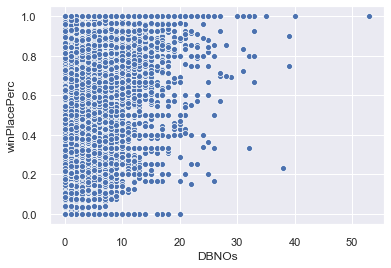

In [67]:
sns.scatterplot(pubg_train.DBNOs,pubg_train.winPlacePerc)

In [52]:
pubg_train.DBNOs=pd.cut(pubg_train.DBNOs,[-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,1000],labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

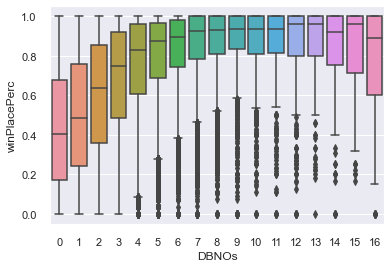

In [69]:
sns.boxplot(x=pubg_train.DBNOs,y=pubg_train.winPlacePerc)

In [70]:
pubg_train.DBNOs.value_counts()

0     2676571
1      982504
2      395001
3      162591
4       69264
5       31642
6       14943
7        7269
8        3669
9        1951
10       1098
11        638
12        460
16        406
13        266
14        174
15        137
Name: DBNOs, dtype: int64

In [71]:
print("The Spearman Correlation Coefficient is: {}".format(stats.spearmanr(pubg_train.DBNOs,pubg_train.winPlacePerc)))

The Spearman Correlation Coefficient is: SpearmanrResult(correlation=0.24266015212234693, pvalue=0.0)


#### Number of enemy players damaged which have been killed by teammate

In [72]:
pubg_train.assists.value_counts()

0     3570801
1      591048
2      136878
3       35465
4        9884
5        2840
6         942
7         362
8         173
9          76
10         43
11         24
12         19
13         15
15          7
14          2
17          2
21          1
20          1
22          1
Name: assists, dtype: int64

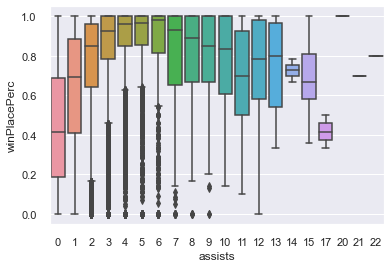

In [73]:
sns.boxplot(x=pubg_train.assists,y=pubg_train.winPlacePerc)

In [53]:
pubg_train.assists=pd.cut(pubg_train.assists,[-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,1000],labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])

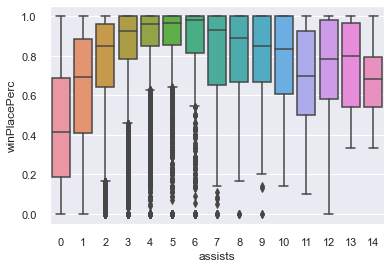

In [75]:
sns.boxplot(x=pubg_train.assists,y=pubg_train.winPlacePerc)

In [76]:
pubg_train.assists.value_counts()

0     3570801
1      591048
2      136878
3       35465
4        9884
5        2840
6         942
7         362
8         173
9          76
10         43
11         24
12         19
13         15
14         14
Name: assists, dtype: int64

In [77]:
print("The Spearman Correlation Coefficient is: {}".format(stats.spearmanr(pubg_train.assists,pubg_train.winPlacePerc)))

The Spearman Correlation Coefficient is: SpearmanrResult(correlation=0.2938659244685693, pvalue=0.0)


#### Count of Boosts taken 

In [78]:
pubg_train.boosts.value_counts()

0     2423470
1      679952
2      491214
3      295825
4      195703
5      120258
6       70100
7       37622
8       18890
9        8633
10       3989
11       1642
12        726
13        295
14        125
15         62
16         30
17         16
18         13
19          6
21          4
20          3
24          2
28          1
22          1
23          1
33          1
Name: boosts, dtype: int64

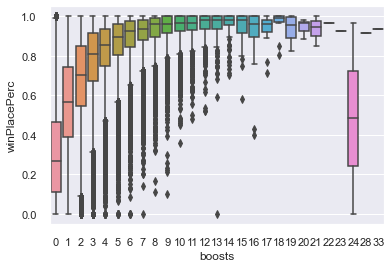

In [79]:
sns.boxplot(x=pubg_train.boosts,y=pubg_train.winPlacePerc)

In [54]:
pubg_train.boosts=pd.cut(pubg_train.boosts,[-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,1000],labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

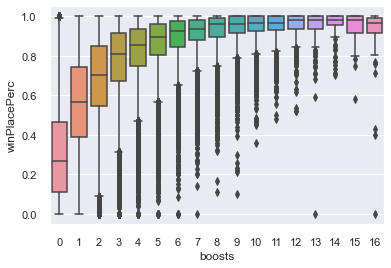

In [81]:
sns.boxplot(x=pubg_train.boosts,y=pubg_train.winPlacePerc)

In [82]:
pubg_train.boosts.value_counts()

0     2423470
1      679952
2      491214
3      295825
4      195703
5      120258
6       70100
7       37622
8       18890
9        8633
10       3989
11       1642
12        726
13        295
14        125
16         78
15         62
Name: boosts, dtype: int64

In [83]:
print("The Spearman Correlation Coefficient is: {}".format(stats.spearmanr(pubg_train.boosts,pubg_train.winPlacePerc)))

The Spearman Correlation Coefficient is: SpearmanrResult(correlation=0.6786275519499574, pvalue=0.0)


#### Damage Dealt given to enemy

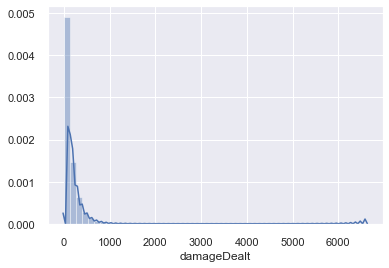

In [84]:
sns.distplot(pubg_train.damageDealt)

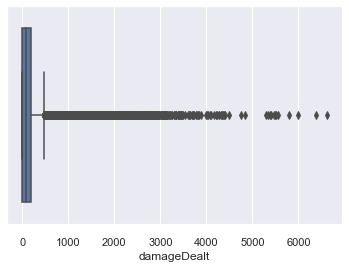

In [85]:
sns.boxplot(pubg_train.damageDealt)

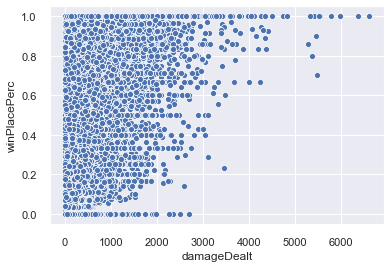

In [86]:
sns.scatterplot(pubg_train.damageDealt,pubg_train.winPlacePerc)

In [55]:
pubg_train.damageDealt=pd.cut(pubg_train.damageDealt,[-1,0,50,200,500,750,1000,2000,3000,4000,5000,60000],labels=[1,2,3,4,5,6,7,8,9,10,11])

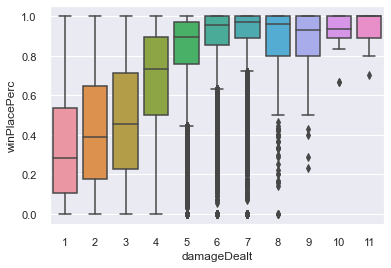

In [88]:
sns.boxplot(x=pubg_train.damageDealt,y=pubg_train.winPlacePerc)

In [89]:
pubg_train.damageDealt.value_counts()

3     1697948
1     1149836
4      781306
2      542097
5      127387
6       34510
7       14907
8         499
9          65
10         17
11         12
Name: damageDealt, dtype: int64

#### Count of headshots

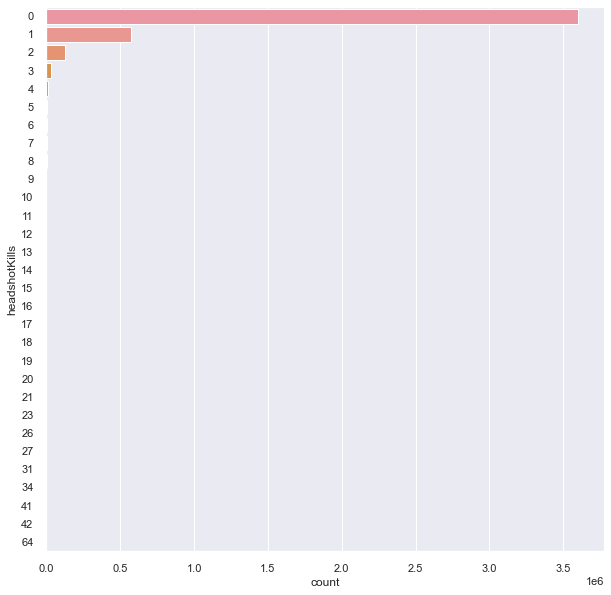

In [90]:
plt.figure(figsize=(10,10))
sns.countplot(y=pubg_train.headshotKills)
plt.show()

In [91]:
pubg_train.headshotKills.value_counts()

0     3599503
1      573507
2      126104
3       32854
4        9885
5        3582
6        1419
7         748
8         369
9         213
10        134
11         77
12         61
13         43
14         23
15         16
16         12
17         11
18          7
19          3
20          3
21          2
42          1
23          1
26          1
27          1
31          1
34          1
41          1
64          1
Name: headshotKills, dtype: int64

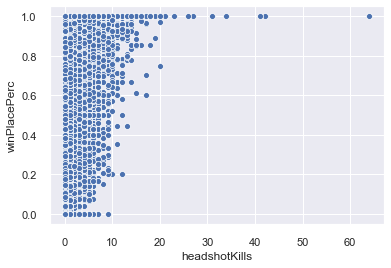

In [92]:
sns.scatterplot(pubg_train.headshotKills,pubg_train.winPlacePerc)

In [56]:
pubg_train.headshotKills=pd.cut(pubg_train.headshotKills,[-1,0,1,2,3,4,5,6,7,8,9,15,20,100],labels=[1,2,3,4,5,6,7,8,9,10,11,12,13])

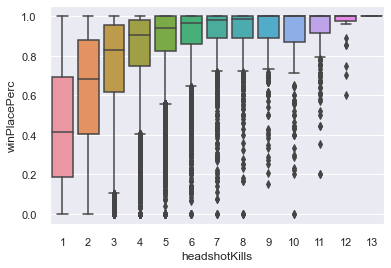

In [94]:
sns.boxplot(x=pubg_train.headshotKills,y=pubg_train.winPlacePerc)

In [95]:
pubg_train.headshotKills.value_counts()

1     3599503
2      573507
3      126104
4       32854
5        9885
6        3582
7        1419
8         748
9         369
11        354
10        213
12         36
13         10
Name: headshotKills, dtype: int64

In [96]:
print("The Spearman Correlation Coefficient is: {}".format(stats.spearmanr(pubg_train.headshotKills,pubg_train.winPlacePerc)))

The Spearman Correlation Coefficient is: SpearmanrResult(correlation=0.27667825744924757, pvalue=0.0)


#### Count of heals

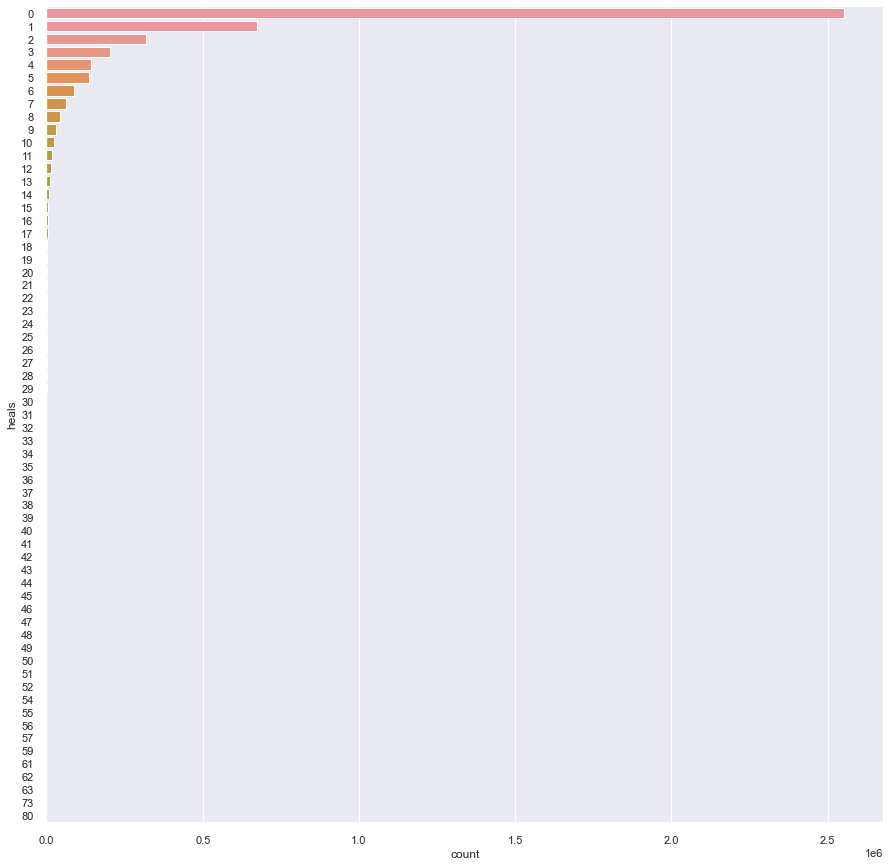

In [97]:
plt.figure(figsize=(15,15))
sns.countplot(y=pubg_train.heals)
plt.show()

In [98]:
pubg_train.heals.value_counts()

0     2550898
1      672674
2      319231
3      202250
4      142545
       ...   
62          1
73          1
57          1
56          1
80          1
Name: heals, Length: 63, dtype: int64

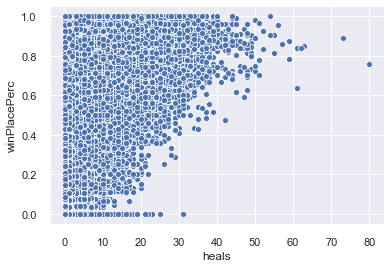

In [99]:
sns.scatterplot(pubg_train.heals,pubg_train.winPlacePerc)

In [57]:
pubg_train.heals=pd.cut(pubg_train.heals,[-1,0,1,2,3,4,5,6,7,8,9,15,20,30,40,50,60,100],labels=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])

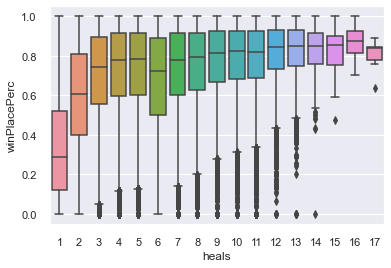

In [101]:
sns.boxplot(x=pubg_train.heals,y=pubg_train.winPlacePerc)

In [102]:
pubg_train.heals.value_counts()

1     2550898
2      672674
3      319231
4      202250
5      142545
6      135142
7       88039
11      80848
8       64051
9       43032
10      30023
12      13927
13       5237
14        572
15         96
16         13
17          6
Name: heals, dtype: int64

In [103]:
print("The Spearman Correlation Coefficient is: {}".format(stats.spearmanr(pubg_train.heals,pubg_train.winPlacePerc)))

The Spearman Correlation Coefficient is: SpearmanrResult(correlation=0.5585998467699053, pvalue=0.0)


#### Kill Place

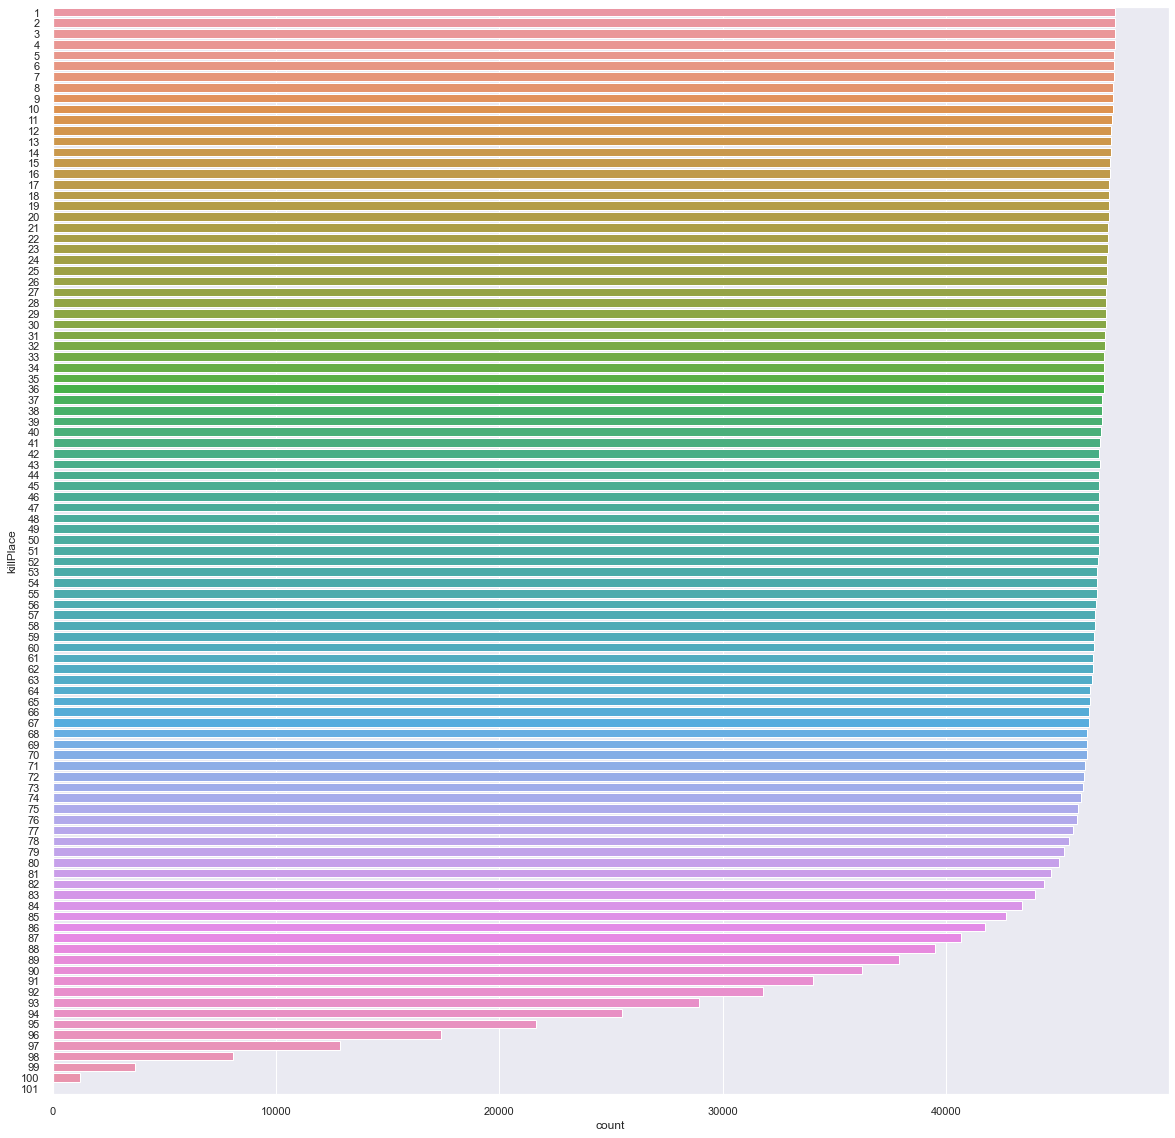

In [104]:
plt.figure(figsize=(20,20))
sns.countplot(y=pubg_train.killPlace)

In [58]:
pubg_train.loc[pubg_train.killPlace==101,'killPlace']=100

In [59]:
print("The Pearson Correlation Coefficient is: {}".format(stats.pearsonr(pubg_train.killPlace,pubg_train.winPlacePerc)))

The Pearson Correlation Coefficient is: (-0.7117888314548697, 0.0)


#### Kill Points

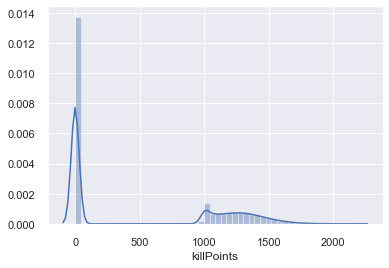

In [107]:
sns.distplot(pubg_train.killPoints)

In [108]:
print("Skewness of Kill Points:",pubg_train.killPoints.skew())

Skewness of Kill Points: 0.5127255110383296


In [109]:
print("The Pearson Correlation Coefficient is: {}".format(stats.pearsonr(pubg_train.killPoints,pubg_train.winPlacePerc)))

The Pearson Correlation Coefficient is: (0.008820683664379457, 1.45792355685664e-75)


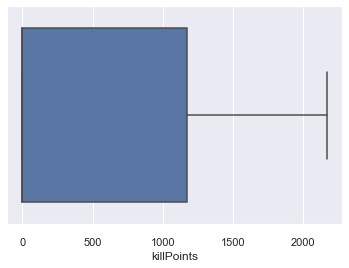

In [110]:
sns.boxplot(pubg_train.killPoints)

#### So Kill Points is not a good predictor with target variable hence we can remove it moreover it is highly correlated with rank points

In [111]:
print("The Pearson Correlation Coefficient is: {}".format(stats.pearsonr(pubg_train.rankPoints,pubg_train.killPoints)))

The Pearson Correlation Coefficient is: (-0.9766965160059728, 0.0)


#### Kill Streaks

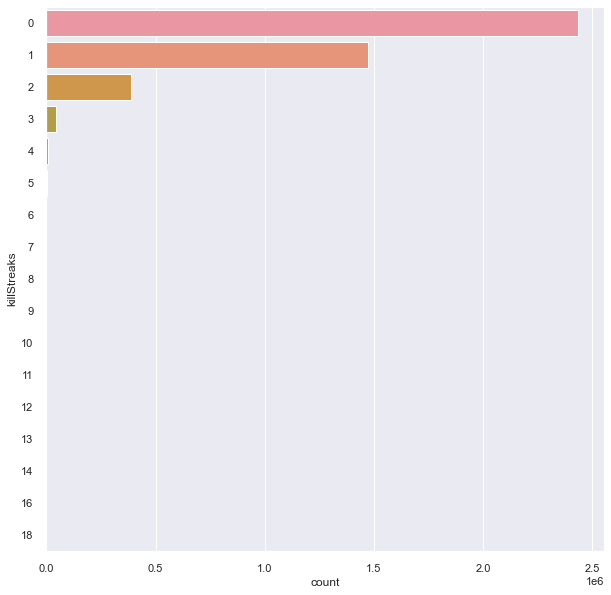

In [112]:
plt.figure(figsize=(10,10))
sns.countplot(y=pubg_train.killStreaks)

In [113]:
pubg_train.killStreaks.value_counts()

0     2433823
1     1473900
2      388782
3       45785
4        5663
5         390
6         121
7          51
8          29
9          14
11          7
10          6
12          5
13          4
14          2
16          1
18          1
Name: killStreaks, dtype: int64

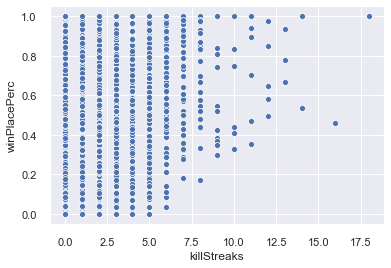

In [114]:
sns.scatterplot(pubg_train.killStreaks,pubg_train.winPlacePerc)

In [60]:
pubg_train.killStreaks=pd.cut(pubg_train.killStreaks,[-1,0,1,2,3,4,5,6,8,10,100],labels=[1,2,3,4,5,6,7,8,9,10])

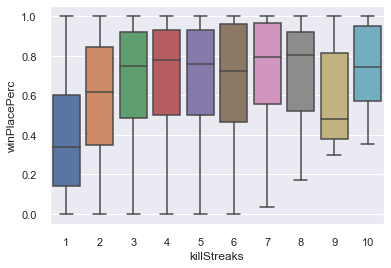

In [116]:
sns.boxplot(x=pubg_train.killStreaks,y=pubg_train.winPlacePerc)

In [117]:
pubg_train.killStreaks.value_counts()

1     2433823
2     1473900
3      388782
4       45785
5        5663
6         390
7         121
8          80
10         20
9          20
Name: killStreaks, dtype: int64

In [118]:
print("The Spearman Correlation Coefficient is: {}".format(stats.spearmanr(pubg_train.killStreaks,pubg_train.winPlacePerc)))

The Spearman Correlation Coefficient is: SpearmanrResult(correlation=0.3790287844498864, pvalue=0.0)


#### Kills 

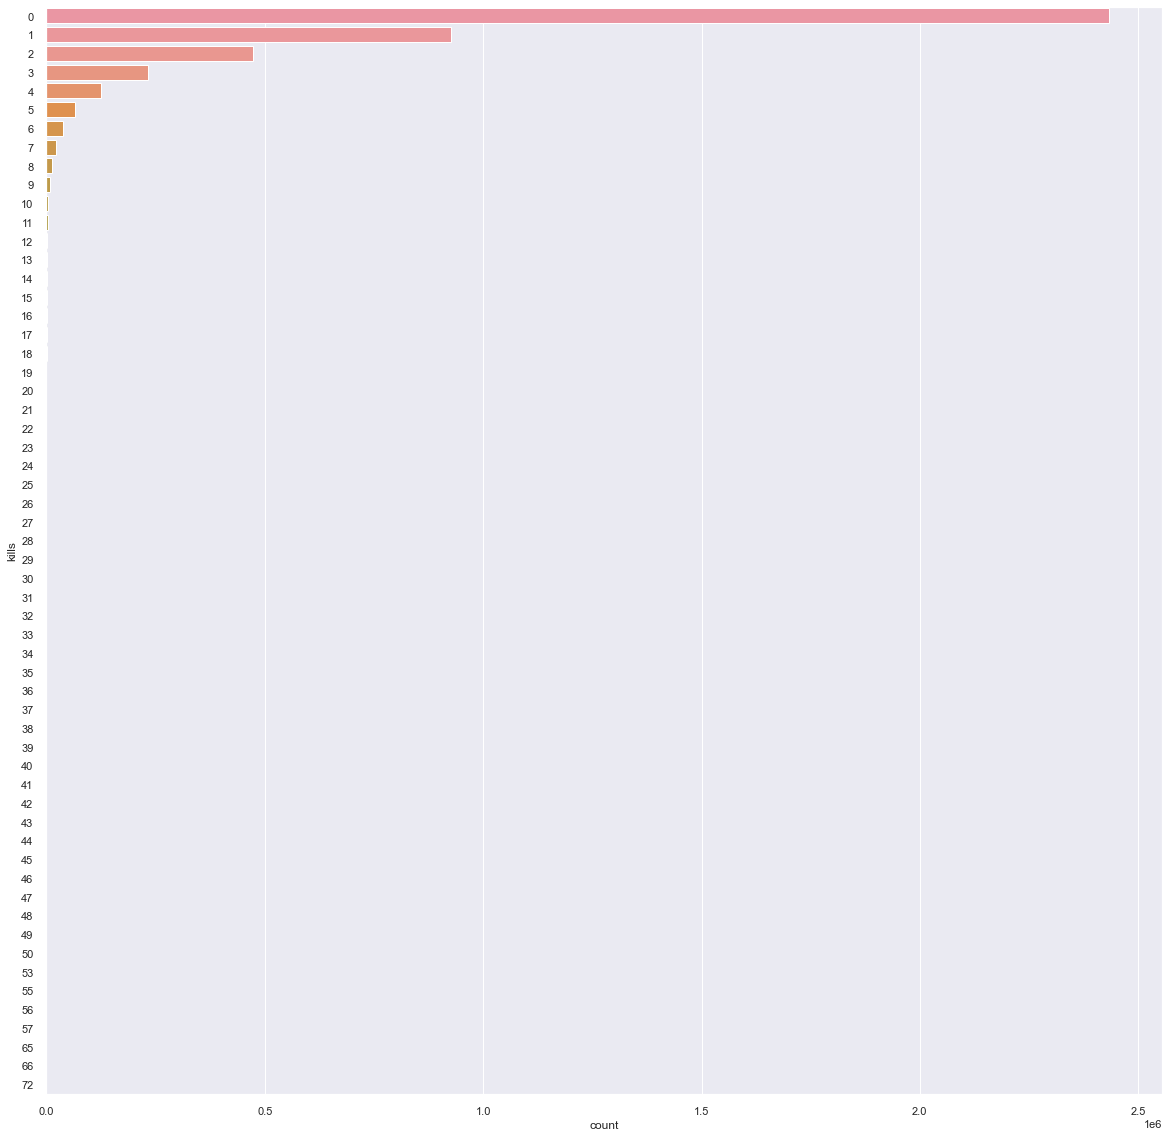

In [119]:
plt.figure(figsize=(20,20))
sns.countplot(y=pubg_train.kills)

In [120]:
pubg_train.kills.value_counts()

0     2433823
1      926927
2      472197
3      232234
4      124383
5       66463
6       37859
7       21737
8       12712
9        7579
10       4561
11       2756
12       1726
13       1108
14        742
15        468
16        317
17        226
18        160
19        105
20         95
22         74
21         61
23         40
24         38
26         24
25         23
28         22
27         15
29         11
30         11
31         11
33         11
35          6
38          6
37          5
36          5
34          5
32          4
39          4
41          4
53          3
46          2
57          2
56          2
55          2
42          2
44          2
43          2
45          1
47          1
48          1
49          1
50          1
66          1
40          1
65          1
72          1
Name: kills, dtype: int64

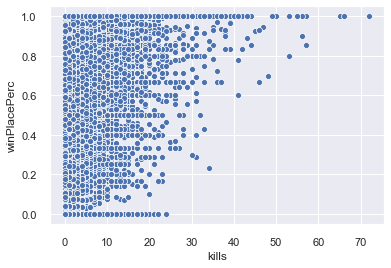

In [121]:
sns.scatterplot(pubg_train.kills,pubg_train.winPlacePerc)

In [61]:
pubg_train.kills=pd.cut(pubg_train.kills,[-1,0,1,2,3,4,5,6,7,8,9,10,15,20,30,40,50,100],labels=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])

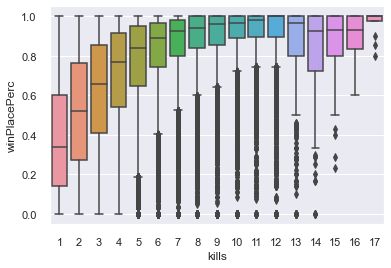

In [123]:
sns.boxplot(x=pubg_train.kills,y=pubg_train.winPlacePerc)

In [124]:
pubg_train.kills.value_counts()

1     2433823
2      926927
3      472197
4      232234
5      124383
6       66463
7       37859
8       21737
9       12712
10       7579
12       6800
11       4561
13        903
14        319
15         58
16         17
17         12
Name: kills, dtype: int64

In [125]:
print("The Spearman Correlation Coefficient is: {}".format(stats.spearmanr(pubg_train.kills,pubg_train.winPlacePerc)))

The Spearman Correlation Coefficient is: SpearmanrResult(correlation=0.4207569319494726, pvalue=0.0)


#### Longest Kill

In [126]:
pubg_train.longestKill.value_counts()

0.000000      2442711
32.625000         738
32.875000         707
33.125000         702
32.125000         699
               ...   
0.340088            1
0.339844            1
0.339600            1
0.338135            1
713.000000          1
Name: longestKill, Length: 11148, dtype: int64

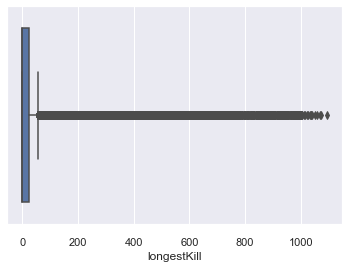

In [127]:
sns.boxplot(pubg_train.longestKill)

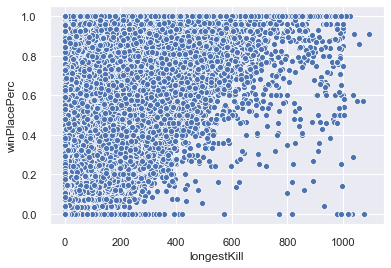

In [128]:
sns.scatterplot(pubg_train.longestKill,pubg_train.winPlacePerc)

In [62]:
pubg_train.longestKill=pd.cut(pubg_train.longestKill,[-1,0,200,400,600,800,1000,50000],labels=[1,2,3,4,5,6,7])

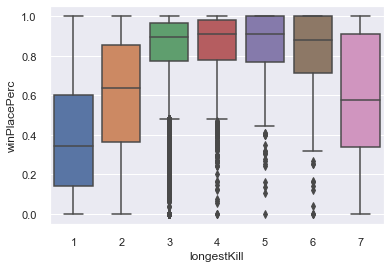

In [130]:
sns.boxplot(x=pubg_train.longestKill,y=pubg_train.winPlacePerc)

In [131]:
pubg_train.longestKill.value_counts()

1    2442711
2    1822657
3      77931
4       4521
5        513
6        233
7         18
Name: longestKill, dtype: int64

#### Removing Variables 

In [63]:
pubg_train.drop(columns=["Id","groupId","matchId"],inplace=True)

In [51]:
print("No of Rows: {} | No. of Columns: {}".format(pubg_train.shape[0],pubg_train.shape[1]))

No of Rows: 4348584 | No. of Columns: 30


#### Previously we saw that roadkills was highly skewed 

In [134]:
pubg_train.roadKills.value_counts()

0     4335632
1       11231
2        1296
3         294
4          63
5          28
6          18
7          11
8           5
11          2
9           2
18          1
10          1
Name: roadKills, dtype: int64

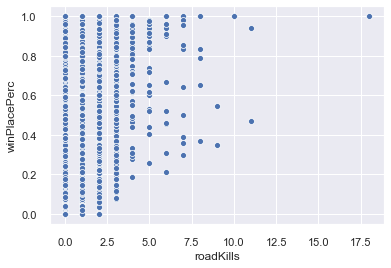

In [135]:
sns.scatterplot(pubg_train.roadKills,pubg_train.winPlacePerc)

In [64]:
pubg_train.roadKills=pd.cut(pubg_train.roadKills,[-1,0,1,2,3,4,6,9,100],labels=[1,2,3,4,5,6,7,8])

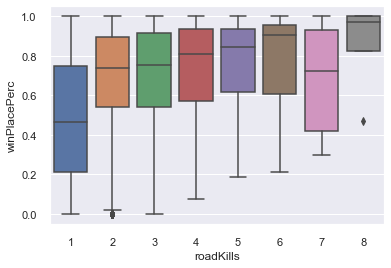

In [137]:
sns.boxplot(x=pubg_train.roadKills,y=pubg_train.winPlacePerc)

In [138]:
pubg_train.roadKills.value_counts()

1    4335632
2      11231
3       1296
4        294
5         63
6         46
7         18
8          4
Name: roadKills, dtype: int64

In [139]:
print("The Spearman Correlation Coefficient is: {}".format(stats.spearmanr(pubg_train.roadKills,pubg_train.winPlacePerc)))

The Spearman Correlation Coefficient is: SpearmanrResult(correlation=0.037959145376182994, pvalue=0.0)


____________________________________________________________________________________________________________________________

#### Separating Target and Independent variables 

In [65]:
final_X=pubg_train.loc[:,pubg_train.columns.difference(["winPlacePerc"])]
final_Y=pubg_train.winPlacePerc

In [66]:
final_X=pd.get_dummies(final_X,columns=["matchType"])

____________________________________________________________________________________________________________________________

#### Train - Test Split
- Since we have a very huge dataset hence we will use 15% of the data set to train our model 

In [67]:
train_X,test_X,train_Y,test_Y=train_test_split(final_X,final_Y,test_size=0.85,random_state=42)

In [146]:
train_X.head()

,DBNOs,Energy,Headshot_Rate,Total_Distance,assists,boosts,damageDealt,headshotKills,heals,killPlace,...,matchType_normal-duo,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp
507581,0,0,1.0,49.875,0,0,3,1,1,52,...,0,0,0,0,0,0,0,0,0,0
2698632,2,0,1.0,776.500,0,0,4,2,1,27,...,0,0,0,0,0,0,0,0,0,1
587868,0,0,1.0,5332.000,3,0,3,1,1,26,...,0,0,0,0,0,0,0,0,1,0
2959648,1,2,1.0,235.125,0,1,3,1,2,76,...,0,0,0,0,0,0,0,0,0,1
1770588,0,5,1.0,223.875,0,1,1,1,5,73,...,0,0,0,0,0,0,0,0,1,0


In [68]:
test_X.head()

,DBNOs,Energy,Headshot_Rate,Total_Distance,assists,boosts,damageDealt,headshotKills,heals,killPlace,...,matchType_normal-duo,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp
2247534,0,1,1.000000,140.00,0,1,1,1,1,75,...,0,0,0,0,0,0,0,0,0,0
2740683,0,0,1.000000,234.75,0,0,1,1,1,77,...,0,0,0,0,0,0,0,0,0,1
1820337,1,2,0.500000,2266.00,0,2,3,1,1,27,...,0,0,0,0,0,0,0,0,0,1
1164530,1,2,0.666667,1560.00,0,1,4,2,2,19,...,0,0,0,0,0,0,0,0,0,0
1613096,0,3,0.333333,3024.00,0,1,5,2,3,3,...,0,0,0,0,0,0,0,1,0,0


In [148]:
train_Y.head()

507581     0.466797
2698632    0.208252
587868     0.884766
2959648    0.296387
1770588    0.239990
Name: winPlacePerc, dtype: float16

In [69]:
train_Y=train_Y.astype('float32')

In [150]:
test_Y.head()

2247534    0.239136
2740683    0.241455
1820337    0.777832
1164530    0.632812
1613096    0.937500
Name: winPlacePerc, dtype: float16

In [70]:
test_Y=test_Y.astype('float32')

In [152]:
print("There are {} rows and {} columns in Train X".format(train_X.shape[0],train_X.shape[1]))
print("There are {} rows and {} column in Train Y".format(train_Y.shape[0],1))
print("There are {} rows and {} columns in Test X".format(test_X.shape[0],test_X.shape[1]))
print("There are {} rows and {} column in Test Y".format(test_Y.shape[0],1))

There are 652287 rows and 44 columns in Train X
There are 652287 rows and 1 column in Train Y
There are 3696297 rows and 44 columns in Test X
There are 3696297 rows and 1 column in Test Y


____________________________________________________________________________________________________________________________

#### Linear Regression- Sklearn

In [76]:
m0=LinearRegression().fit(train_X,train_Y)

In [77]:
print("The R squared for the train is:", m0.score(train_X,train_Y))

The R squared for the train is: 0.8555746801232922


In [78]:
print("The R squared for the test is:", m0.score(test_X,test_Y))

The R squared for the test is: 0.8563210725781817


____________________________________________________________________________________________________________________________

#### Metrics: MAE & RMSE

#### RMSE for Intercept only model - Train

In [156]:
avg_train=np.mean(train_Y)
s_train=pd.Series(avg_train)
pred_train=m0.predict(train_X)

In [157]:
y_true_Base_Model=s_train.repeat(repeats=len(train_X))

In [158]:
RMSE_Base_Model=mean_squared_error(y_true=y_true_Base_Model,y_pred=pred_train)

In [159]:
print("RMSE for Intercept Only Model for Train Data Set is: ",np.sqrt(RMSE_Base_Model))

RMSE for Intercept Only Model for Train Data Set is:  0.2803911825163723


____________________________________________________________________________________________________________________________

#### RMSE for Full model - Train

In [160]:
y_true_Full_Model=train_Y

In [161]:
RMSE_Full_Model=mean_squared_error(y_true=train_Y,y_pred=pred_train)

In [162]:
print("RMSE for Full Model is: ",np.sqrt(RMSE_Full_Model))

RMSE for Full Model is:  0.11520121491376872


____________________________________________________________________________________________________________________________

#### RMSE for Intercept only model - Test

In [163]:
avg_test=np.mean(test_Y)
s_test=pd.Series(avg_test)
pred_test=m0.predict(test_X)

In [164]:
y_true_Base_Model=s_test.repeat(repeats=len(test_X))

In [165]:
RMSE_Base_Model=mean_squared_error(y_true=y_true_Base_Model,y_pred=pred_test)

In [166]:
print("RMSE for Intercept Only Model for Test Data Set is: ",np.sqrt(RMSE_Base_Model))

RMSE for Intercept Only Model for Test Data Set is:  0.28056231534001075


____________________________________________________________________________________________________________________________

#### RMSE for Full model - Test

In [167]:
y_true_Full_Model=test_Y

In [168]:
RMSE_Full_Model=mean_squared_error(y_true=test_Y,y_pred=pred_test)

In [169]:
print("RMSE for Full Model for Test Data Set is: ",np.sqrt(RMSE_Full_Model))

RMSE for Full Model for Test Data Set is:  0.11489498143320906


____________________________________________________________________________________________________________________________

#### MAE for Full Model - Train

In [170]:
print("MAE for Train Data Set with Full Model is",mean_absolute_error(train_Y,m0.predict(train_X)))

MAE for Train Data Set with Full Model is 0.08418647392295361


#### MAE for Full Model - Test

In [171]:
print("MAE for Test Data Set with Full Model is",mean_absolute_error(test_Y,m0.predict(test_X)))

MAE for Test Data Set with Full Model is 0.08388447651614582


____________________________________________________________________________________________________________________________

#### Decision Tree Model

In [80]:
d0=DecisionTreeRegressor().fit(train_X,train_Y)

In [81]:
print("The R squared for the train is:", d0.score(train_X,train_Y))

The R squared for the train is: 1.0


In [174]:
print("The R squared for the test is:", d0.score(test_X,test_Y))

The R squared for the test is: 0.844752774362393


- So we can clearly see that this is the case of Overfitting hence we need to tune the parameters of the tree

____________________________________________________________________________________________________________________________

#### Decision Tree with Tuning the Parameters

##### Grid Search CV 

In [80]:
para={  'max_depth': [20,25,30],
        'min_samples_split':[90,95,100],
    'min_samples_leaf':[16,18,20]}

In [81]:
random_tree=GridSearchCV(DecisionTreeRegressor(random_state=42),param_grid=para,n_jobs=-1,verbose=10,cv=3).fit(train_X,train_Y)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done  75 out of  81 | elapsed: 12.4min remaining:   59.6s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 13.0min finished


In [87]:
print("The Best Score on Cross Validated Data is: {}".format(np.abs(random_tree.best_score_)))
print("The Best Parameters are : {}".format((random_tree.best_params_)))

The Best Score on Cross Validated Data is: 0.9083478971651252
The Best Parameters are : {'max_depth': 20, 'min_samples_leaf': 20, 'min_samples_split': 100}


In [72]:
d1=DecisionTreeRegressor(max_depth=20,min_samples_leaf=20,min_samples_split=100).fit(train_X,train_Y)

In [73]:
print("The R squared for the train is:", d1.score(train_X,train_Y))

The R squared for the train is: 0.9266000404162197


In [74]:
print("The R squared for the test is:", d1.score(test_X,test_Y))

The R squared for the test is: 0.9113108096534295


#### Feature Importances

In [159]:
a=(pd.DataFrame(d1.feature_importances_,train_X.columns,columns=["Importance"])).sort_values(by="Importance",ascending=False)

In [153]:
b=a.reset_index()

In [155]:
b.columns=["Features","Importance"]

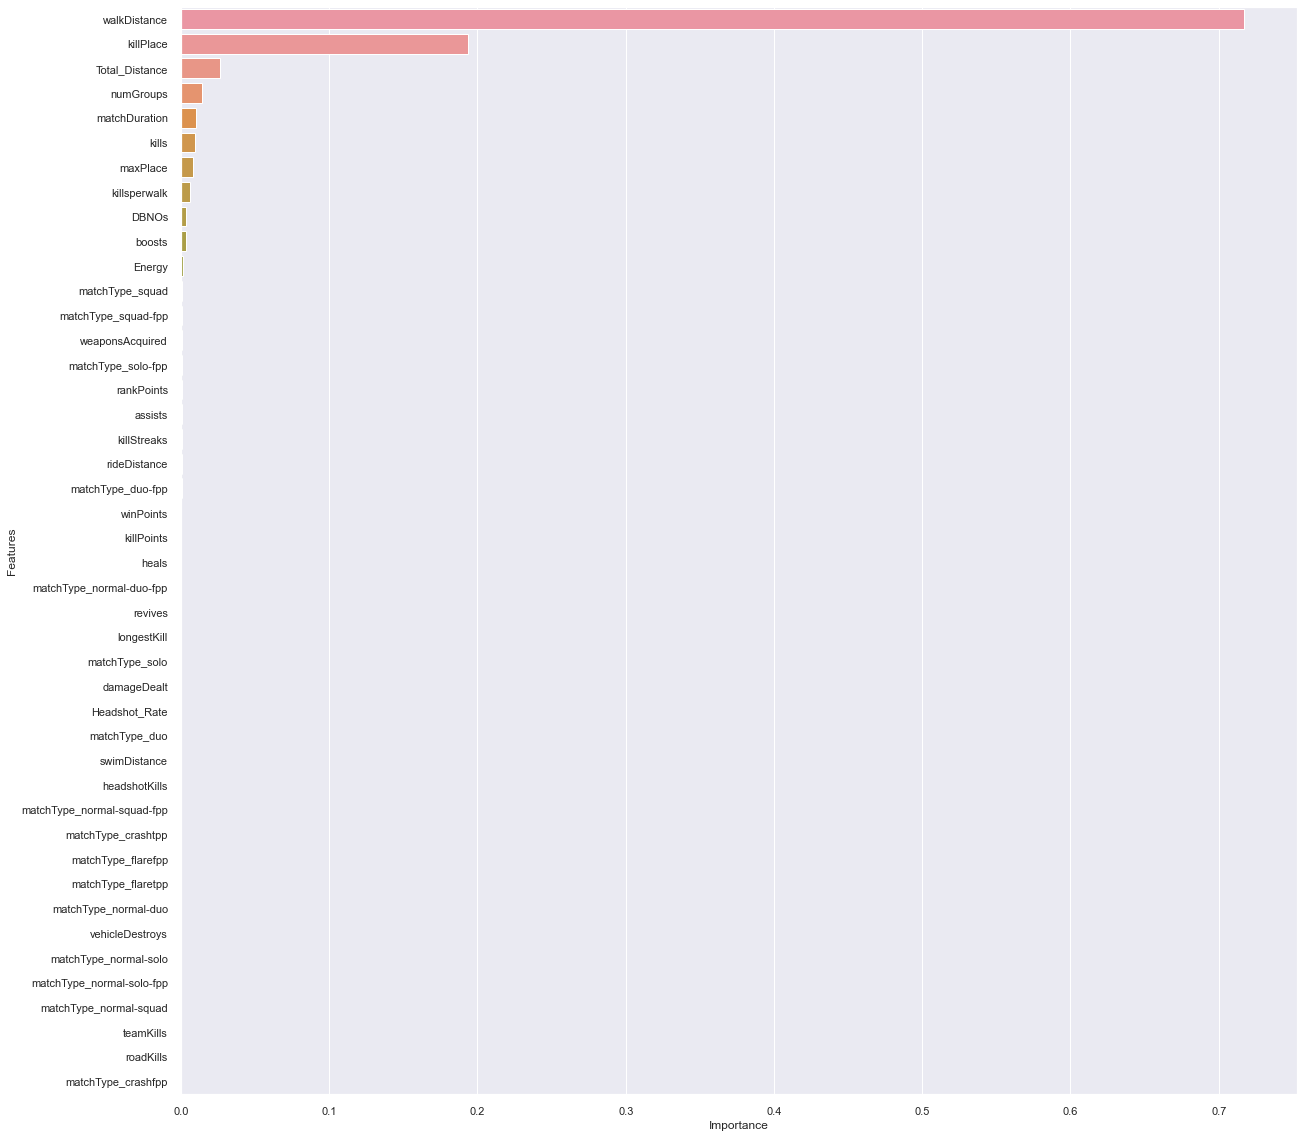

In [158]:
plt.figure(figsize=(20,20))
sns.barplot(y=b.Features,x=b.Importance)

____________________________________________________________________________________________________________________________

#### Metrics: MAE & RMSE

#### RMSE for Intercept only model - Train

In [97]:
avg_train=np.mean(train_Y)
s_train=pd.Series(avg_train)
pred_train=d1.predict(train_X)

In [98]:
y_true_Base_Model=s_train.repeat(repeats=len(train_X))

In [99]:
RMSE_Base_Model=mean_squared_error(y_true=y_true_Base_Model,y_pred=pred_train)

In [100]:
print("RMSE for Intercept Only Model for Train Data Set is: ",np.sqrt(RMSE_Base_Model))

RMSE for Intercept Only Model for Train Data Set is:  0.29179748838481573


____________________________________________________________________________________________________________________________

#### RMSE for Full model - Train

In [101]:
y_true_Full_Model=train_Y

In [102]:
RMSE_Full_Model=mean_squared_error(y_true=train_Y,y_pred=pred_train)

In [103]:
print("RMSE for Full Model is: ",np.sqrt(RMSE_Full_Model))

RMSE for Full Model is:  0.08212649342846792


____________________________________________________________________________________________________________________________

#### RMSE for Intercept only model - Test

In [104]:
avg_test=np.mean(test_Y)
s_test=pd.Series(avg_test)
pred_test=d1.predict(test_X)

In [105]:
y_true_Base_Model=s_test.repeat(repeats=len(test_X))

In [106]:
RMSE_Base_Model=mean_squared_error(y_true=y_true_Base_Model,y_pred=pred_test)

In [107]:
print("RMSE for Intercept Only Model for Test Data Set is: ",np.sqrt(RMSE_Base_Model))

RMSE for Intercept Only Model for Test Data Set is:  0.29194026924233


____________________________________________________________________________________________________________________________

#### RMSE for Full model - Test

In [108]:
y_true_Full_Model=test_Y

In [109]:
RMSE_Full_Model=mean_squared_error(y_true=test_Y,y_pred=pred_test)

In [110]:
print("RMSE for Full Model for Test Data Set is: ",np.sqrt(RMSE_Full_Model))

RMSE for Full Model for Test Data Set is:  0.09026710196488101


____________________________________________________________________________________________________________________________

#### MAE for Full Model - Train

In [111]:
print("MAE for Train Data Set with Full Model is",mean_absolute_error(train_Y,d1.predict(train_X)))

MAE for Train Data Set with Full Model is 0.05839277527358723


#### MAE for Full Model - Test

In [112]:
print("MAE for Test Data Set with Full Model is",mean_absolute_error(test_Y,d1.predict(test_X)))

MAE for Test Data Set with Full Model is 0.06415816357278667


____________________________________________________________________________________________________________________________

#### Random Forest Model

In [117]:
r0=RandomForestRegressor().fit(train_X,train_Y)

In [118]:
r0.score(train_X,train_Y)

0.989195601715629

In [119]:
r0.score(test_X,test_Y)

0.9234724080922134

____________________________________________________________________________________________________________________________

In [87]:
a=pd.Series(["Linear Regression","Decison Tree without tuning","Decision Tree with Tuning","Random Forest without tuning"])

In [89]:
b=pd.Series([m0.score(test_X,test_Y),d0.score(test_X,test_Y),d1.score(test_X,test_Y),0.923472])

In [90]:
c=pd.Series([m0.score(train_X,train_Y),d0.score(train_X,train_Y),d1.score(train_X,train_Y),0.989195])

In [105]:
d=pd.DataFrame([a,b,c]).T

In [106]:
d.columns=["Model","Test R-Squared","Train R-Squared"]

____________________________________________________________________________________________________________________________

In [108]:
d

,Model,Test R-Squared,Train R-Squared
0,Linear Regression,0.856321,0.855575
1,Decison Tree without tuning,0.844493,1
2,Decision Tree with Tuning,0.911311,0.9266
3,Random Forest without tuning,0.923472,0.989195


- Hence we will go with decision tree with tuning 

____________________________________________________________________________________________________________________________

#### Prediction With Decison Tree with Tuning Model for Train Data

In [124]:
tree_pred_train=pd.concat([pd.Series(d1.predict(train_X)),train_Y.reset_index(drop=True),],axis=1)

In [125]:
tree_pred_train.columns=["Predicted","True"]

In [126]:
tree_pred_train

,Predicted,True
0,0.483001,0.466797
1,0.363697,0.208252
2,0.940566,0.884766
3,0.230148,0.296387
4,0.252502,0.239990
...,...,...
652282,0.635021,0.666504
652283,0.450148,0.428711
652284,0.296051,0.291748
652285,0.150134,0.148926


____________________________________________________________________________________________________________________________

#### Prediction With Decison Tree with Tuning Model for Test Data

In [127]:
tree_pred_test=pd.concat([pd.Series(d1.predict(test_X)),test_Y.reset_index(drop=True),],axis=1)

In [128]:
tree_pred_test.columns=["Predicted","True"]

In [129]:
tree_pred_test

,Predicted,True
0,0.223521,0.239136
1,0.236891,0.241455
2,0.760328,0.777832
3,0.655418,0.632812
4,0.933398,0.937500
...,...,...
3696292,0.334669,0.357178
3696293,0.201591,0.199951
3696294,0.906474,1.000000
3696295,0.201372,0.178589


____________________________________________________________________________________________________________________________

# THANK YOU!!